In [1]:
import matplotlib.pyplot as plt
import timm
from ultralytics import YOLO

import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms

In [2]:
text_det_model_path = 'yolo.pt' # Scene detection model
yolo = YOLO(text_det_model_path)

In [3]:
!nvidia-smi

Sun Jun  8 23:46:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.28                 Driver Version: 576.28         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0  On |                  N/A |
| 85%   68C    P0             72W /   75W |    3049MiB /   4096MiB |     79%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
class CRNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        backbone = timm.create_model("resnet152", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(), nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )

    @torch.autocast(device_type="cuda")
    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  # Based on CTC

        return x
        
chars = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz²³µ¹¼½¾ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÑÒÓÔÕÖØÙÚÛÜÝßàáâãäåæçèéêëìíîïñòóôõöøùúûüýÿĀāĂăĄąĆćċČčĐĒēĖėęĚěġĩĪİıĺĽŁŃńňŉŌōŎőŒŘřŚśşŠšŢţŤũŪūŮůŰźŻżŽžƃƉƠơƬƯưǏǒǪǵȂȇȊȍȎȏȓȕȗțȮəɮʃʰˉˢˣΔΡΣΦΩίαβελνπστϋабвгдежиклмнопрстуъыьэײبرل٢٣ڮڽۊᴐᴰᴱᴴᴵᴸᴹᴺᵀᵃᵈᵉᵐᵒᵗᵛᶜᶻᶾḂḎḕḢḻṁṅṫẏẢẤẦầẬẮẶẾỀềỆọỐốồỘỢό⁰⁵⁷⁸⁹ⁿ₁₃₄ₓₘₙₜℇℒΩℱ⅓⅔ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩⅪⅫ①②❶➀➁➂➃➄➅➋➌➍➎ⱽ卐ꝋ𝕵-'
vocab_size = len(chars)
char_to_idx = {char: idx + 1 for idx , char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers=3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = 'checkpoint.pt'

crnn_model = CRNN(
    vocab_size = vocab_size,
    hidden_size = hidden_size,
    n_layers = n_layers,
    dropout = dropout_prob,
    unfreeze_layers = unfreeze_layers
).to(device)

checkpoint = torch.load('ocr_crnn.pt') # Text Recognition model
crnn_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None # To track the previous character

        for token in seq:
            if token != 0: # Ignore padding (token = 0)
                char = idx_to_char[token.item()]
                # Append the character if it ’s not a blank or the same as the previous character

                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char # Update previous character

        decoded_sequences.append("".join(decoded_label))
    print(f"From {encoded_sequences} to {decoded_sequences}")
    
    return decoded_sequences


In [6]:
def text_detection(img_path, text_det_model) :
    text_det_results = text_det_model(img_path, verbose = False)[0]
    
    bboxes = text_det_results.boxes.xyxy.tolist()
    classes = text_det_results.boxes.cls.tolist()
    names = text_det_results.names
    confs = text_det_results.boxes.conf.tolist()
    
    return bboxes, classes, names, confs

In [7]:
def text_recognition(img , data_transforms , text_reg_model , idx_to_char ,device):
    transformed_image = data_transforms(img)
    transformed_image = transformed_image.unsqueeze(0).to(device)
    text_reg_model.eval()
    with torch.no_grad() :
        logits = text_reg_model(transformed_image).detach().cpu().log_softmax(2)
    text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)
    
    return text

In [8]:
def visualize_detections(img, detections):
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.axis('off')

    for bbox, detected_class, confidence, transcribed_text in detections:
        x1, y1, x2, y2 = bbox
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False,edgecolor='red', linewidth=2))
        plt.text(
            x1, y1 - 10, f'{detected_class} ({confidence:.2f}): {transcribed_text}',
            fontsize=9, bbox=dict(facecolor='red', alpha=0.5)
        )
    plt.show()

In [9]:
data_transforms = {
    'train': transforms.Compose(
        [
            transforms.Resize((100 , 420) ) ,
            transforms.ColorJitter (brightness =0.5, contrast =0.5, saturation=0.5) ,
            transforms.Grayscale(num_output_channels =1) ,
            transforms.GaussianBlur(3) ,
            transforms.RandomAffine(degrees =1, shear =1) ,
            transforms.RandomPerspective(distortion_scale =0.2, p =0.3, interpolation = 3) ,
            transforms.RandomRotation (degrees =2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    'val': transforms.Compose(
        [
            transforms.Resize((100, 420) ) ,
            transforms.Grayscale(num_output_channels =1) ,
            transforms.ToTensor() ,
            transforms.Normalize((0.5,), (0.5,) )
        ]
    )
}

In [10]:
def predict(img_path, data_transforms, text_det_model, text_reg_model, idx_to_char, device):
    #Detection
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)

    # Load the image
    img = Image.open(img_path)

    predictions = []

    #Iterate through the results
    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox
        confidence = conf
        detected_class = cls
        name = names[int(cls)]

        # Extract the detected object and crop it
        cropped_image = img.crop((x1, y1, x2, y2))

        transcribed_text = text_recognition(
            cropped_image,
            data_transforms,
            text_reg_model,
            idx_to_char,
            device
        )
        predictions.append((bbox, name, confidence, transcribed_text))

    visualize_detections(img, predictions)

    return predictions


From tensor([[47,  1,  1,  1, 58,  1,  1,  1, 56,  1,  1, 57,  1,  1]]) to ['just']
From tensor([[44,  1,  1,  1,  1,  1, 52,  1,  1,  1, 57,  1,  1,  1]]) to ['got']
From tensor([[13,  1,  1,  1,  1, 58,  1,  1,  1,  1, 62,  1,  1,  1]]) to ['Buy']
From tensor([[57,  1,  1, 38,  1, 56,  1, 57,  1, 46, 42,  1, 55,  1]]) to ['tastier']
From tensor([[26,  1,  1,  1,  1,  1, 51,  1,  1,  1, 42,  1,  1,  1]]) to ['One']
From tensor([[16,  1, 59, 59, 42, 55, 55, 62, 41, 41, 38,  1, 62,  1]]) to ['Everyday']
From tensor([[18,  1,  1,  1,  1,  1,  1, 42,  1,  1, 57,  1,  1,  1]]) to ['Get']
From tensor([[43,  1,  1,  1,  1,  1, 52,  1,  1, 55,  1,  1,  1,  1]]) to ['for']
From tensor([[24,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]) to ['M']
From tensor([[24,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]) to ['M']
From tensor([[13,  1, 26,  1, 23,  1, 15,  1, 30, 20,  1, 31, 16,  1]]) to ['BOLDSITE']


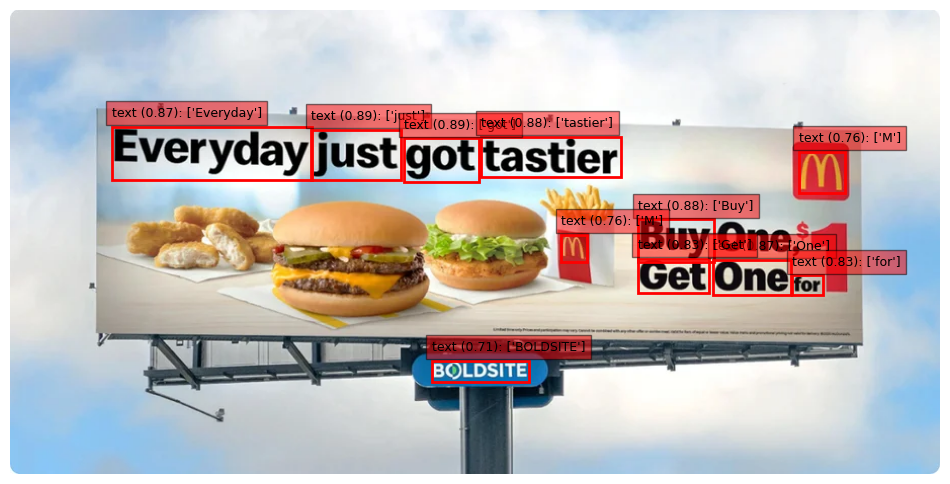

['just']
['got']
['Buy']
['tastier']
['One']
['Everyday']
['Get']
['for']
['M']
['M']
['BOLDSITE']


In [13]:
img_path = '../mcdonald.webp'
#img_path = './burger.jpg'
predictions = predict(
    img_path,
    data_transforms['train'],
    yolo,
    crnn_model,
    idx_to_char,
    device
)
for bbox, name, confidence, transcribed_text in predictions:
    print(transcribed_text)